# Portfolio Optimization: Traditional vs Crypto Assets

This notebook implements three portfolio optimization methods:
1. Mean-Variance Optimization (Tangency Portfolio)
2. Risk Parity
3. CVaR-Constrained Optimization

Each method is applied to both traditional and crypto asset universes with rolling out-of-sample evaluation.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add cmds to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'cmds'))
import portfolio_management_helper as pmh

# Constants
MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

TRADING_DAYS = 252
ROLL_WINDOW = 252  # 1-year rolling window

# Asset universes
TRAD_ASSETS = ["^SPX", "AGG", "IEF", "VNQ", "GLD"]
CRYPTO_ASSETS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD"]

# Create output directories
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

print("Setup complete.")


Setup complete.


## 1. Data Loading and Preparation


In [2]:
# Load and process data
prices = pmh.read_excel_default(MASTER_CSV, sheet_name=None) if MASTER_CSV.endswith('.xlsx') else pd.read_csv(MASTER_CSV, index_col=0, parse_dates=True)

# If CSV, parse dates manually
if isinstance(prices, pd.DataFrame):
    prices.index = pd.to_datetime(prices.index)
    
# Calculate returns
returns_all = prices.pct_change().dropna()

# Extract returns for specified assets
trad_available = [a for a in TRAD_ASSETS if a in returns_all.columns]
crypto_available = [a for a in CRYPTO_ASSETS if a in returns_all.columns]

print(f"Traditional assets: {trad_available}")
print(f"Crypto assets: {crypto_available}")

returns_trad = returns_all[trad_available].dropna()
returns_crypto = returns_all[crypto_available].dropna()

# Align to overlapping period
overlap_start = max(returns_trad.index[0], returns_crypto.index[0])
overlap_end = min(returns_trad.index[-1], returns_crypto.index[-1])

returns_trad = returns_trad.loc[overlap_start:overlap_end]
returns_crypto = returns_crypto.loc[overlap_start:overlap_end]

print(f"\nOverlapping period: {overlap_start.date()} to {overlap_end.date()}")
print(f"Traditional: {returns_trad.shape[0]} days, {returns_trad.shape[1]} assets")
print(f"Crypto: {returns_crypto.shape[0]} days, {returns_crypto.shape[1]} assets")


Traditional assets: ['^SPX', 'AGG', 'IEF', 'VNQ', 'GLD']
Crypto assets: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

Overlapping period: 2022-08-01 to 2025-10-30
Traditional: 817 days, 5 assets
Crypto: 817 days, 5 assets


## 2. Helper Functions


In [3]:
def rolling_oos_portfolio(returns, weights_func_name, window=252, **kwargs):
    """
    Rolling OOS optimization with proper handling of pmh functions.
    
    Parameters:
    -----------
    returns : pd.DataFrame
        Asset returns (simple returns, not excess)
    weights_func_name : str
        Name of optimization method: 'tangency', 'risk_parity', 'cvar'
    window : int
        Rolling window size
    """
    oos_returns = []
    weights_history = []
    dates = []
    
    for i in range(window, len(returns)):
        returns_is = returns.iloc[i-window:i]
        
        try:
            # Get weights based on method
            if weights_func_name == 'tangency':
                weights_df = pmh.calc_tangency_weights(returns_is)
                weights = weights_df.iloc[:, 0]
            elif weights_func_name == 'risk_parity':
                weights_df = pmh.calc_risk_parity_weights(returns_is)
                weights = weights_df.iloc[:, 0]
            elif weights_func_name == 'cvar':
                weights = cvar_optimization(returns_is, **kwargs)
            else:
                raise ValueError(f"Unknown method: {weights_func_name}")
            
            # Normalize
            weights = weights / weights.sum()
            
            # OOS return
            oos_ret = (returns.iloc[i] * weights).sum()
            oos_returns.append(oos_ret)
            weights_history.append(weights)
            dates.append(returns.index[i])
        except Exception as e:
            continue
    
    return pd.Series(oos_returns, index=dates, name='Portfolio'), pd.DataFrame(weights_history, index=dates)


def cvar_optimization(returns, quantile=0.05, verbose=False):
    """
    Simplified CVaR-constrained portfolio optimization.
    
    Uses mean-variance with CVaR penalty instead of hard constraint
    to avoid computational issues.
    """
    n = returns.shape[1]
    T = returns.shape[0]
    
    # Simple approach: Minimize CVaR while targeting reasonable return
    # This is much faster than constrained optimization
    
    try:
        w = cp.Variable(n)
        z = cp.Variable(T)
        alpha = cp.Variable()
        
        mu = returns.mean().values
        returns_matrix = returns.values
        
        # Portfolio returns for each period
        port_returns = returns_matrix @ w
        
        # CVaR constraints (vectorized)
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            z >= 0,
            z >= -port_returns - alpha  # Vectorized constraint
        ]
        
        # CVaR value
        cvar_value = alpha + (1.0 / quantile) * cp.sum(z) / T
        
        # Objective: Maximize return while minimizing CVaR
        # Balance between return and risk
        lambda_risk = 2.0  # Risk aversion parameter
        objective = cp.Maximize(mu @ w - lambda_risk * cvar_value)
        
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS, verbose=False, max_iters=100)
        
        if problem.status in ['optimal', 'optimal_inaccurate']:
            if w.value is not None and not np.any(np.isnan(w.value)):
                weights = pd.Series(np.maximum(w.value, 0), index=returns.columns)
                weights = weights / weights.sum()
                return weights
    except:
        pass
    
    # Fallback: Use minimum variance portfolio
    try:
        w = cp.Variable(n)
        cov_matrix = returns.cov().values
        
        constraints = [
            cp.sum(w) == 1,
            w >= 0
        ]
        
        # Minimize variance
        objective = cp.Minimize(cp.quad_form(w, cov_matrix))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.OSQP, verbose=False)
        
        if problem.status in ['optimal', 'optimal_inaccurate']:
            if w.value is not None:
                weights = pd.Series(np.maximum(w.value, 0), index=returns.columns)
                weights = weights / weights.sum()
                return weights
    except:
        pass
    
    # Ultimate fallback: equal weights
    return pd.Series(np.ones(n) / n, index=returns.columns)


def calc_performance_metrics(returns, annual_factor=252):
    """Calculate performance metrics for a return series."""
    returns_clean = returns.dropna()
    
    total_return = (1 + returns_clean).prod()
    years = len(returns_clean) / annual_factor
    cagr = total_return ** (1 / years) - 1 if years > 0 else 0
    vol = returns_clean.std() * np.sqrt(annual_factor)
    sharpe = (returns_clean.mean() / returns_clean.std()) * np.sqrt(annual_factor) if returns_clean.std() > 0 else 0
    
    downside_ret = returns_clean[returns_clean < 0]
    downside_std = downside_ret.std() if len(downside_ret) > 0 else returns_clean.std()
    sortino = (returns_clean.mean() / downside_std) * np.sqrt(annual_factor) if downside_std > 0 else 0
    
    cum_returns = (1 + returns_clean).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    
    var_5 = returns_clean.quantile(0.05)
    cvar_5 = returns_clean[returns_clean <= var_5].mean()
    
    return {
        'CAGR': cagr,
        'Ann. Vol': vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max DD': max_dd,
        'CVaR (5%)': cvar_5
    }


print("Helper functions defined.")


Helper functions defined.


In [4]:
# Plotting functions
def plot_comparison(returns_dict, title, filename_prefix):
    """Plot equity curves and drawdowns for comparison."""
    # Equity curves
    fig, ax = plt.subplots(figsize=(12, 6))
    for name, rets in returns_dict.items():
        cum_ret = (1 + rets).cumprod()
        ax.plot(cum_ret.index, cum_ret.values, label=name, linewidth=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title(f'{title}: Equity Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'{filename_prefix}_equity.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Drawdowns
    fig, ax = plt.subplots(figsize=(12, 6))
    for name, rets in returns_dict.items():
        cum_ret = (1 + rets).cumprod()
        running_max = cum_ret.cummax()
        drawdown = (cum_ret - running_max) / running_max
        ax.plot(drawdown.index, drawdown.values, label=name, linewidth=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.set_title(f'{title}: Drawdowns')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'{filename_prefix}_dd.png'), dpi=300, bbox_inches='tight')
    plt.show()


def plot_weights_heatmap(weights_df, title, filename):
    """Plot heatmap of portfolio weights."""
    fig, ax = plt.subplots(figsize=(14, 6))
    weights_monthly = weights_df.resample('M').last()
    sns.heatmap(weights_monthly.T, cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Weight'}, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Asset')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, filename), dpi=300, bbox_inches='tight')
    plt.show()


print("Plotting functions defined.")


Plotting functions defined.


## 3. Run All Portfolio Optimizations


In [5]:
print("=" * 80)
print("RUNNING ALL PORTFOLIO OPTIMIZATIONS")
print("=" * 80)

# Dictionary to store all results
all_portfolios = {}
all_weights = {}

# Method 1: MVO/Tangency
print("\n1. MVO/Tangency Portfolio")
print("-" * 40)
mvo_trad_rets, mvo_trad_wts = rolling_oos_portfolio(returns_trad, 'tangency', ROLL_WINDOW)
mvo_crypto_rets, mvo_crypto_wts = rolling_oos_portfolio(returns_crypto, 'tangency', ROLL_WINDOW)
all_portfolios['Trad MVO'] = mvo_trad_rets
all_portfolios['Crypto MVO'] = mvo_crypto_rets
all_weights['mvo_trad'] = mvo_trad_wts
all_weights['mvo_crypto'] = mvo_crypto_wts
print(f"  Traditional: {len(mvo_trad_rets)} OOS obs")
print(f"  Crypto: {len(mvo_crypto_rets)} OOS obs")

# Method 2: Risk Parity
print("\n2. Risk Parity")
print("-" * 40)
rp_trad_rets, rp_trad_wts = rolling_oos_portfolio(returns_trad, 'risk_parity', ROLL_WINDOW)
rp_crypto_rets, rp_crypto_wts = rolling_oos_portfolio(returns_crypto, 'risk_parity', ROLL_WINDOW)
all_portfolios['Trad RP'] = rp_trad_rets
all_portfolios['Crypto RP'] = rp_crypto_rets
all_weights['rp_trad'] = rp_trad_wts
all_weights['rp_crypto'] = rp_crypto_wts
print(f"  Traditional: {len(rp_trad_rets)} OOS obs")
print(f"  Crypto: {len(rp_crypto_rets)} OOS obs")

# Method 3: CVaR-Constrained
print("\n3. CVaR-Constrained")
print("-" * 40)
cvar_trad_rets, cvar_trad_wts = rolling_oos_portfolio(returns_trad, 'cvar', ROLL_WINDOW, quantile=0.05)
cvar_crypto_rets, cvar_crypto_wts = rolling_oos_portfolio(returns_crypto, 'cvar', ROLL_WINDOW, quantile=0.05)
all_portfolios['Trad CVaR'] = cvar_trad_rets
all_portfolios['Crypto CVaR'] = cvar_crypto_rets
all_weights['cvar_trad'] = cvar_trad_wts
all_weights['cvar_crypto'] = cvar_crypto_wts
print(f"  Traditional: {len(cvar_trad_rets)} OOS obs")
print(f"  Crypto: {len(cvar_crypto_rets)} OOS obs")

print("\n" + "=" * 80)
print("ALL OPTIMIZATIONS COMPLETE")
print("=" * 80)


RUNNING ALL PORTFOLIO OPTIMIZATIONS

1. MVO/Tangency Portfolio
----------------------------------------
  Traditional: 565 OOS obs
  Crypto: 565 OOS obs

2. Risk Parity
----------------------------------------
  Traditional: 565 OOS obs
  Crypto: 565 OOS obs

3. CVaR-Constrained
----------------------------------------
  Traditional: 565 OOS obs
  Crypto: 565 OOS obs

ALL OPTIMIZATIONS COMPLETE


## 4. Performance Analysis


In [6]:
# Calculate performance metrics for all portfolios
all_metrics = {}
for name, rets in all_portfolios.items():
    all_metrics[name] = calc_performance_metrics(rets)

comparison_df = pd.DataFrame(all_metrics).T

print("\n" + "=" * 80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 80)
print(comparison_df)

# Save comprehensive comparison
comparison_df.to_csv(os.path.join(TABLE_DIR, 'all_portfolios_comparison.csv'))

# Save individual method comparisons
for method, prefix in [('MVO', 'mvo'), ('RP', 'risk_parity'), ('CVaR', 'cvar')]:
    # Filter rows that contain the method name
    method_rows = [idx for idx in comparison_df.index if method in idx]
    if len(method_rows) > 0:
        method_df = comparison_df.loc[method_rows]
        method_df.to_csv(os.path.join(TABLE_DIR, f'{prefix}_performance.csv'))

# Save weights
for name, wts in all_weights.items():
    wts.to_csv(os.path.join(TABLE_DIR, f'portfolio_weights_{name}.csv'))

print("\nResults saved to", TABLE_DIR)



COMPREHENSIVE PERFORMANCE COMPARISON
               CAGR  Ann. Vol  Sharpe  Sortino  Max DD  CVaR (5%)
Trad MVO     0.1787    0.0870  1.9347   2.7096 -0.0469    -0.0121
Crypto MVO  -0.3905    1.4401  0.5025   0.5684 -0.9318    -0.2295
Trad RP      0.0892    0.0615  1.4195   2.2284 -0.0520    -0.0081
Crypto RP    0.9751    0.5046  1.6021   2.4122 -0.3808    -0.0676
Trad CVaR    0.0825    0.0563  1.4369   2.2441 -0.0492    -0.0075
Crypto CVaR  1.2602    0.4673  1.9800   3.0807 -0.2736    -0.0612

Results saved to outputs/tables


## 5. Method-by-Method Comparisons



Method 1: MVO/Tangency


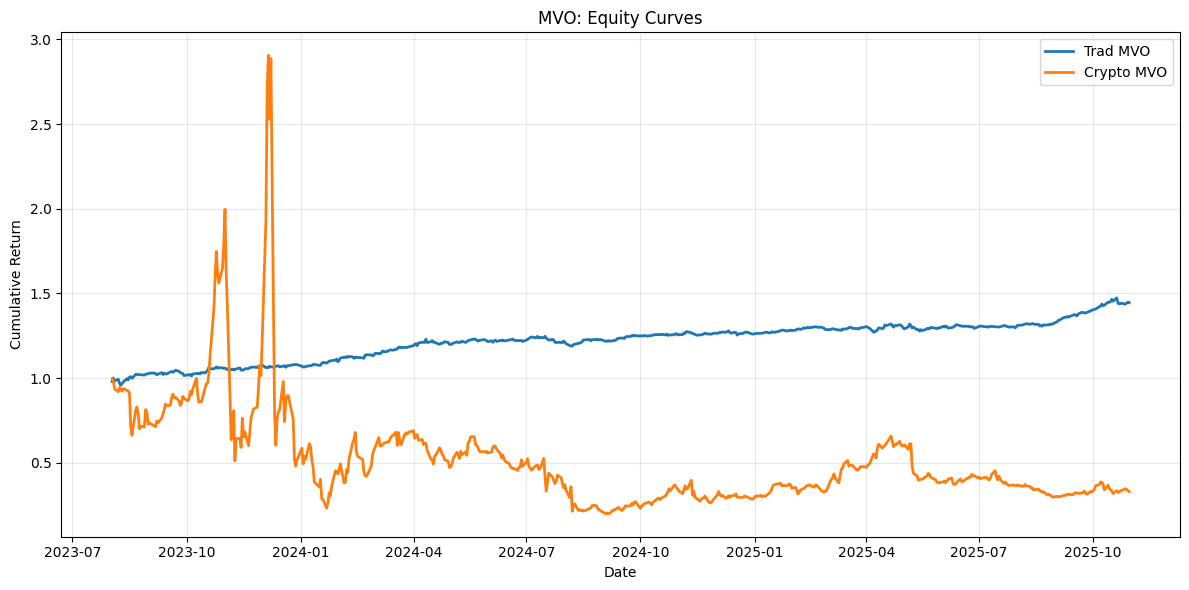

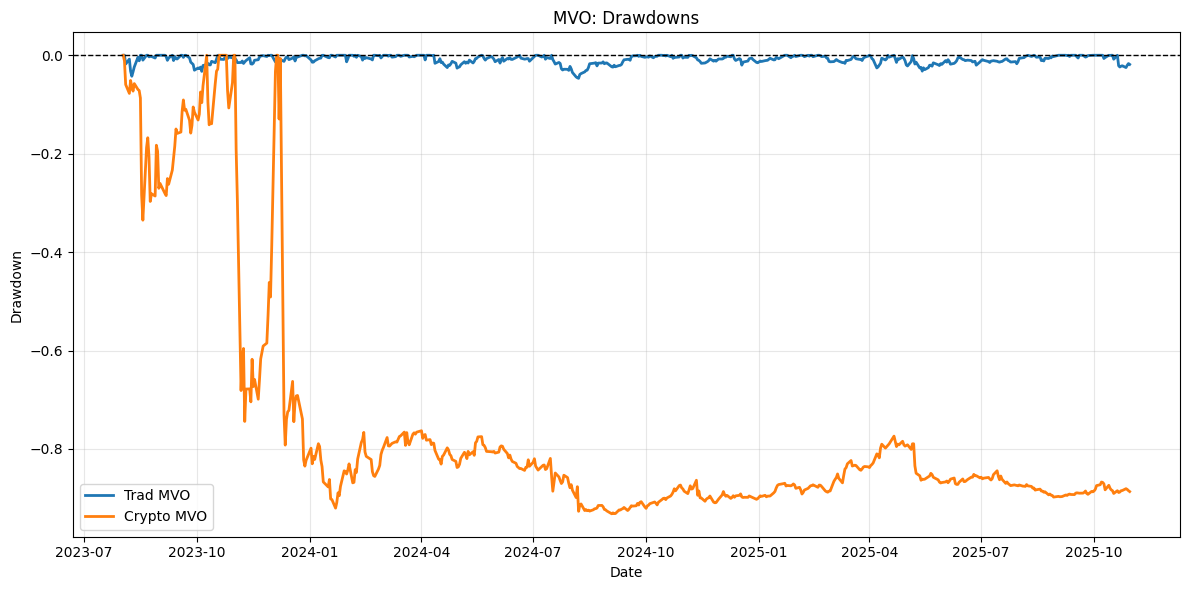

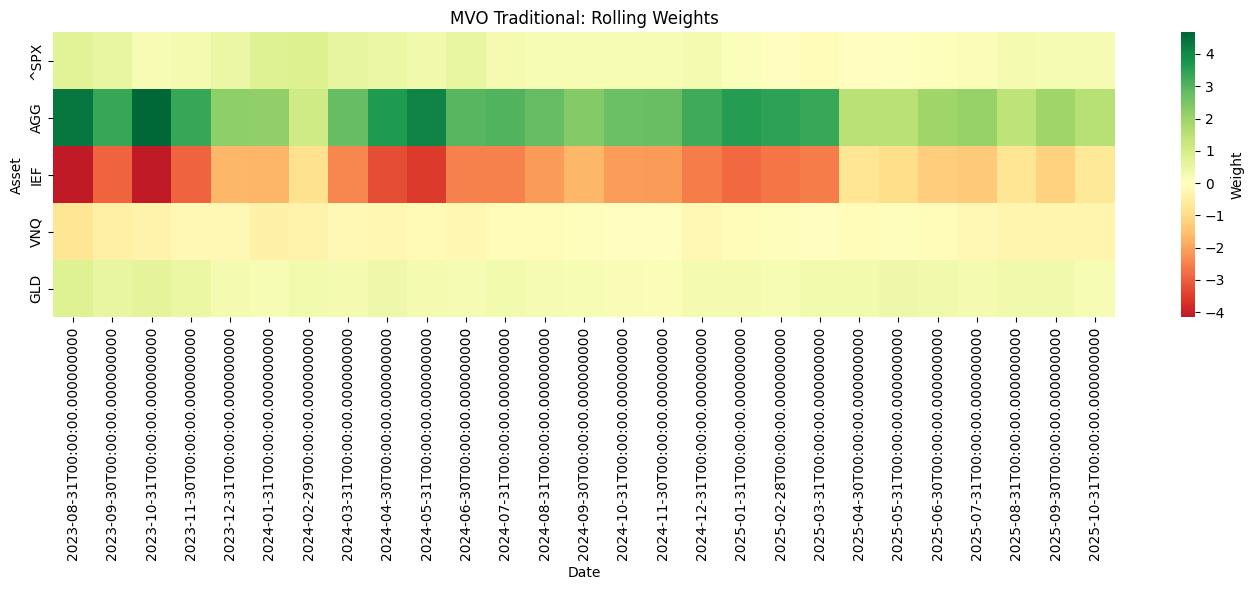

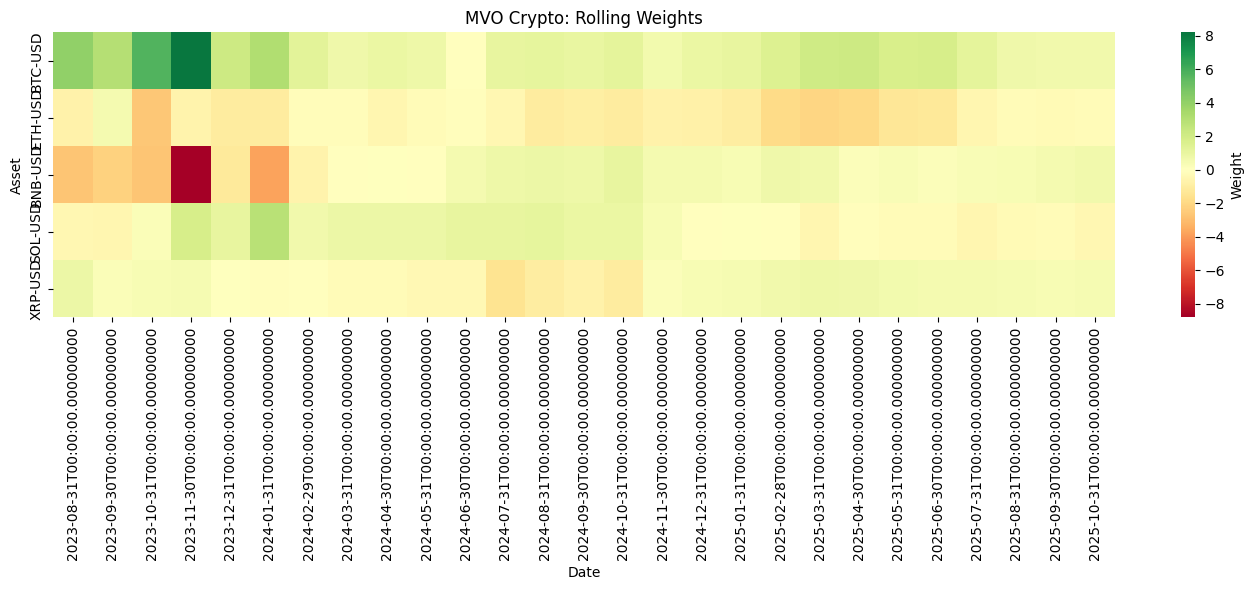


Method 2: Risk Parity


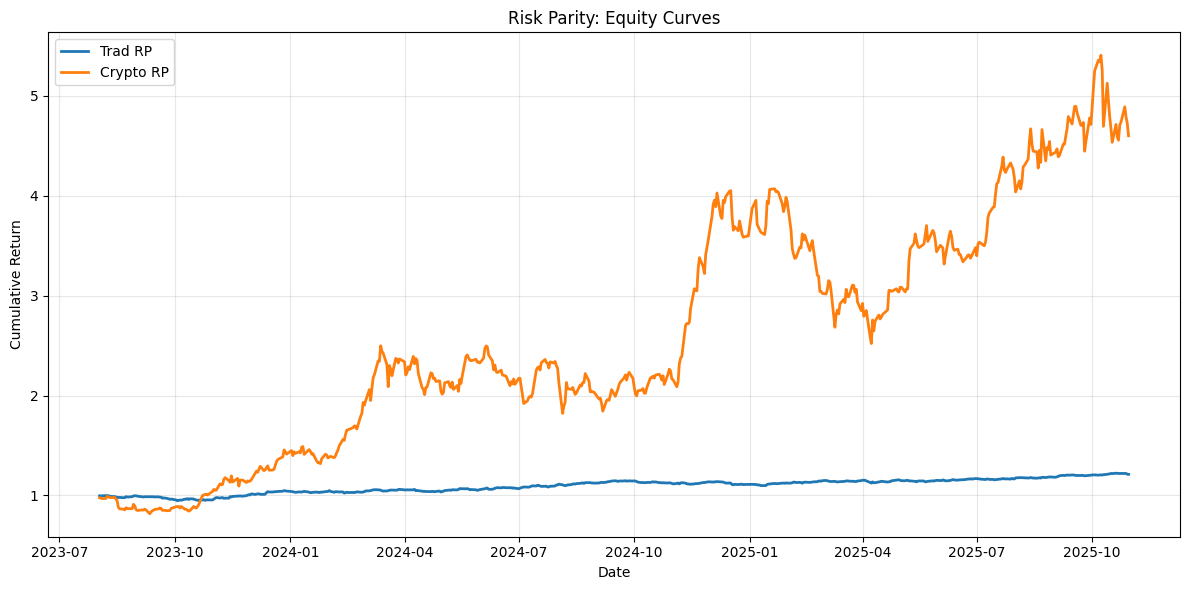

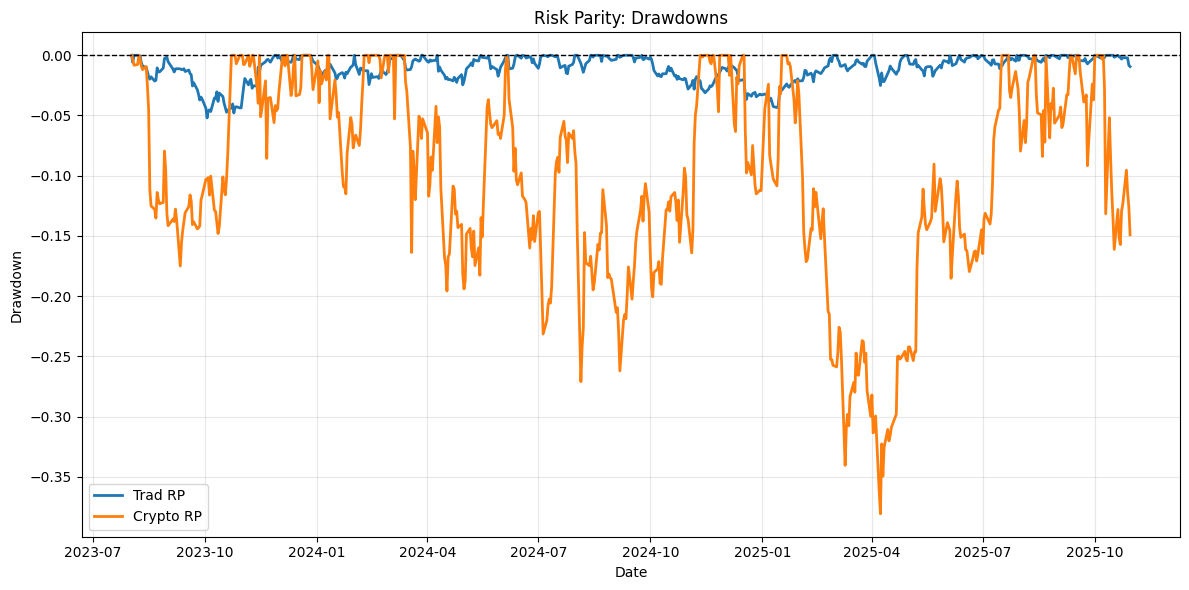

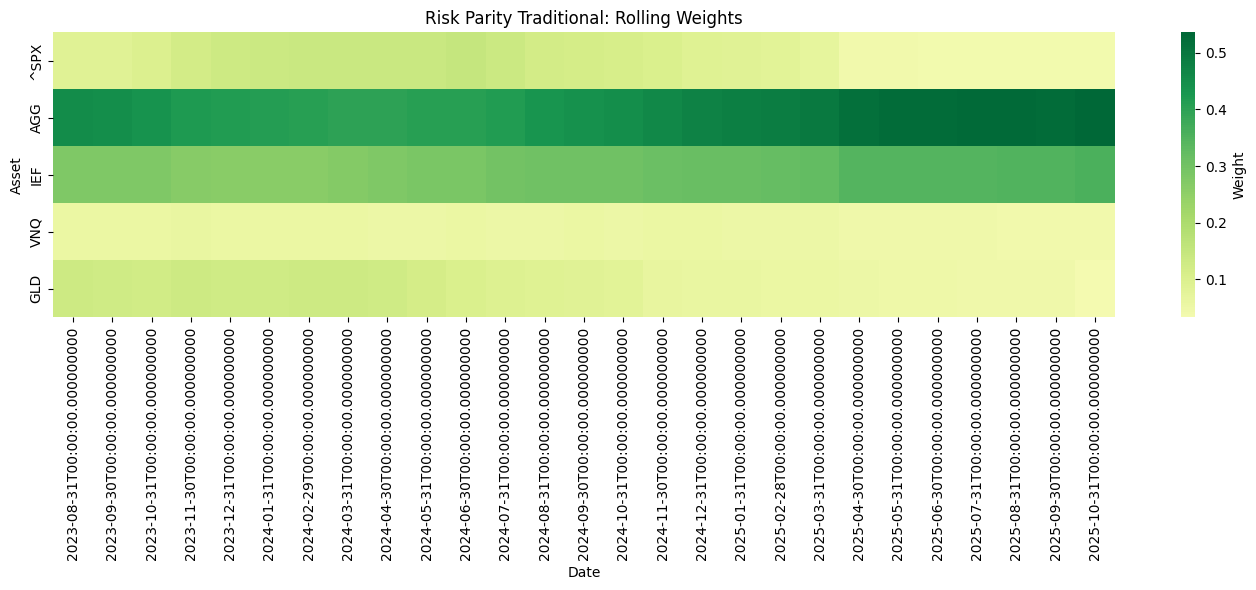

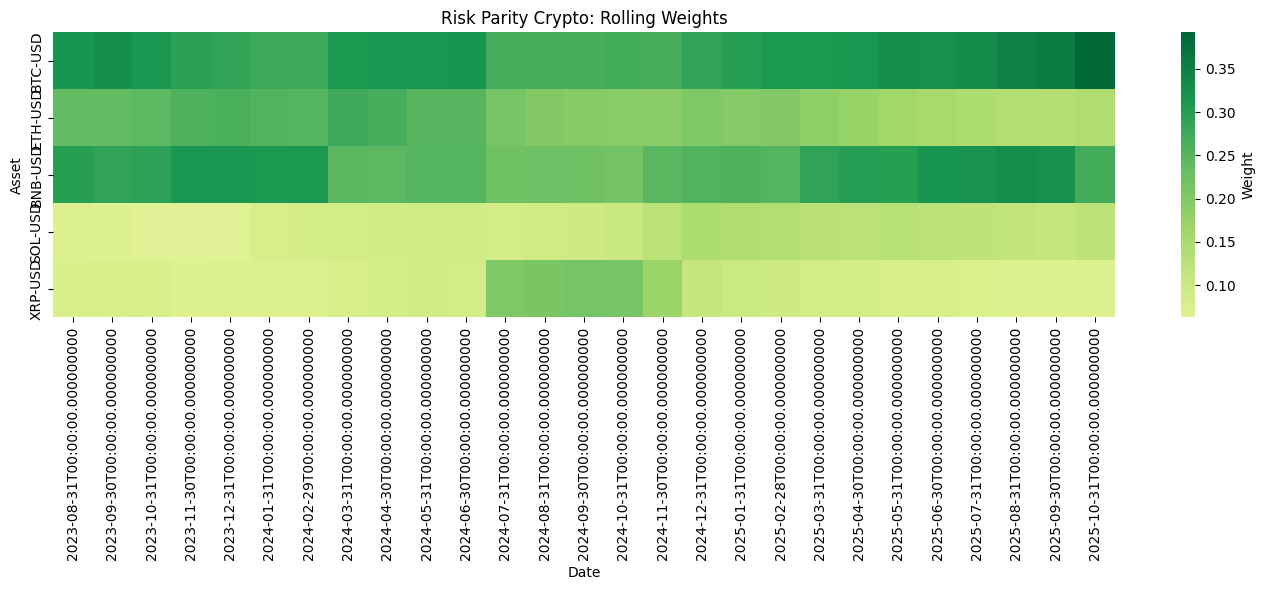


Method 3: CVaR-Constrained


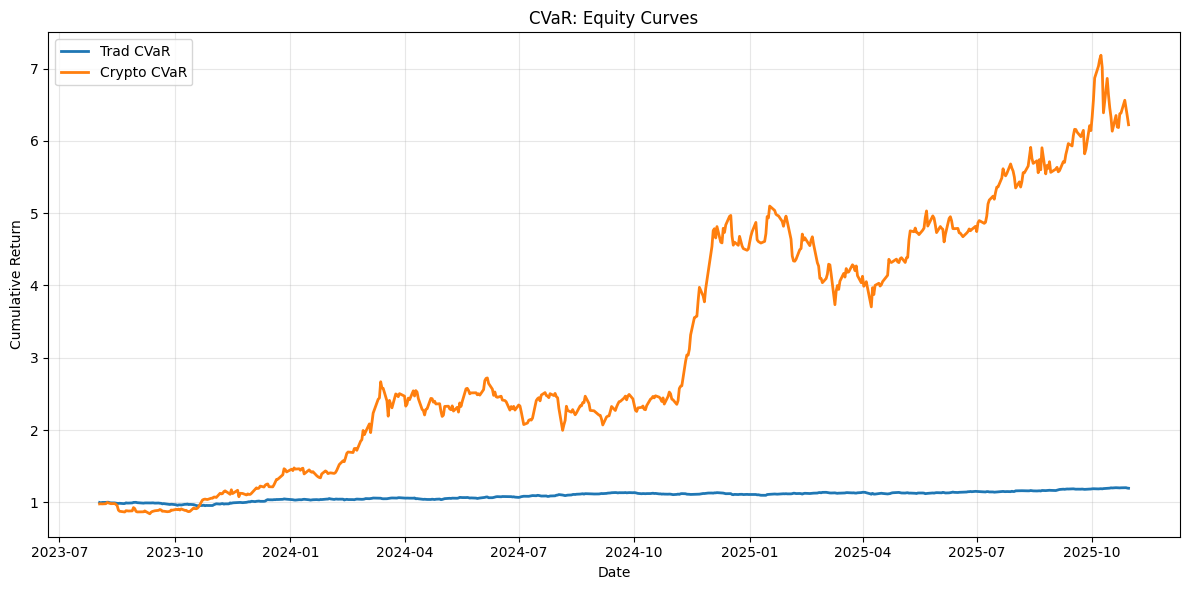

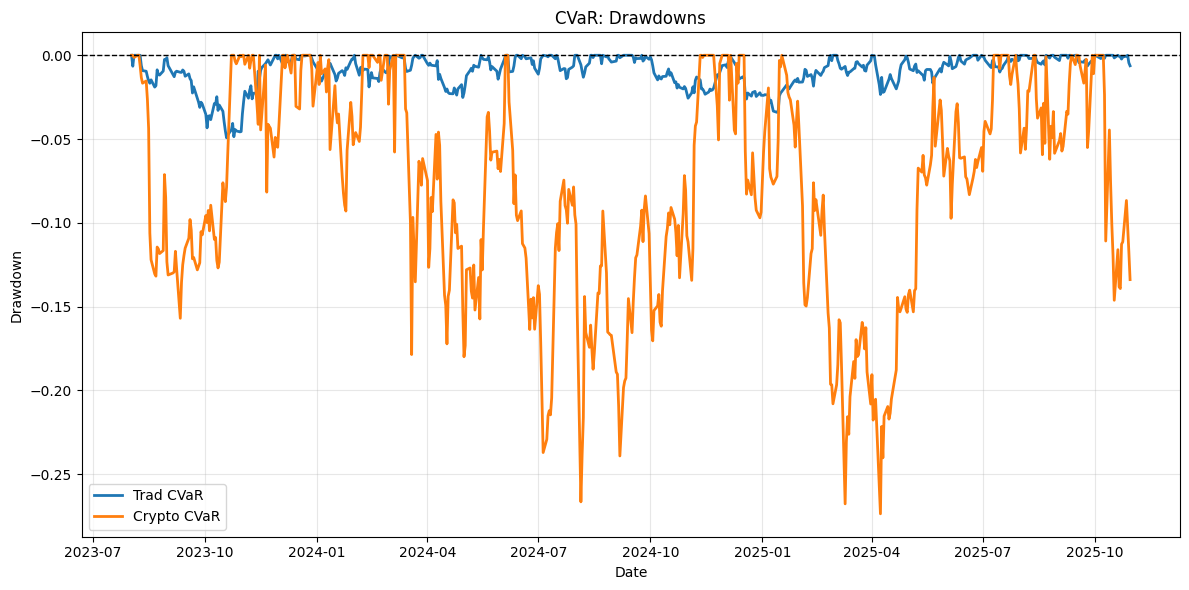

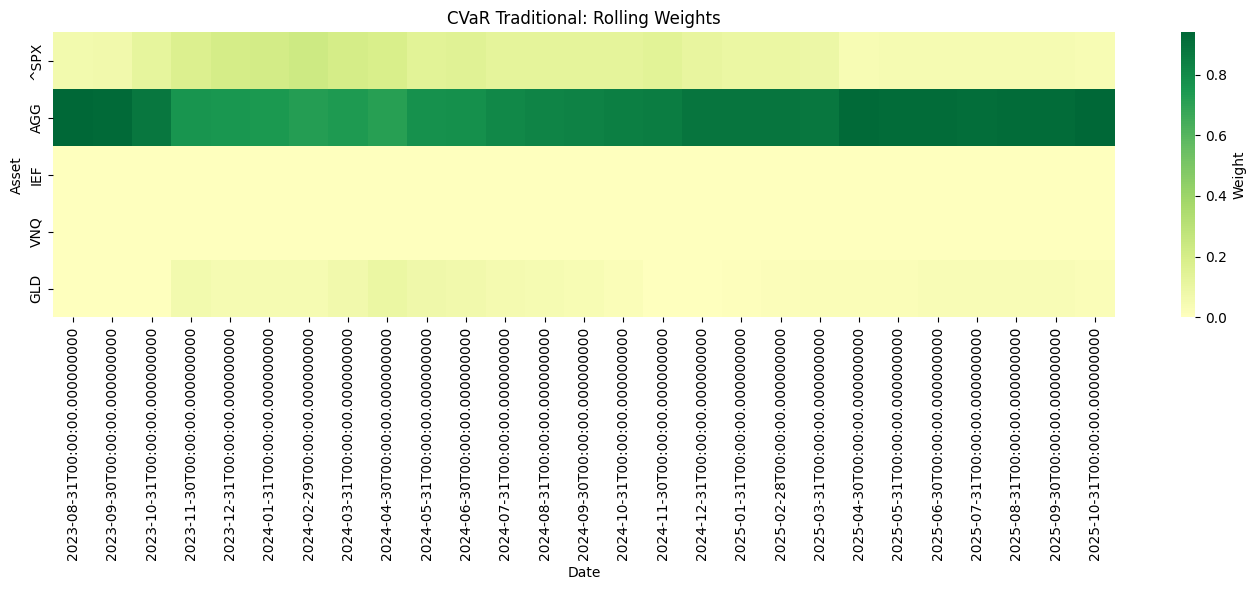

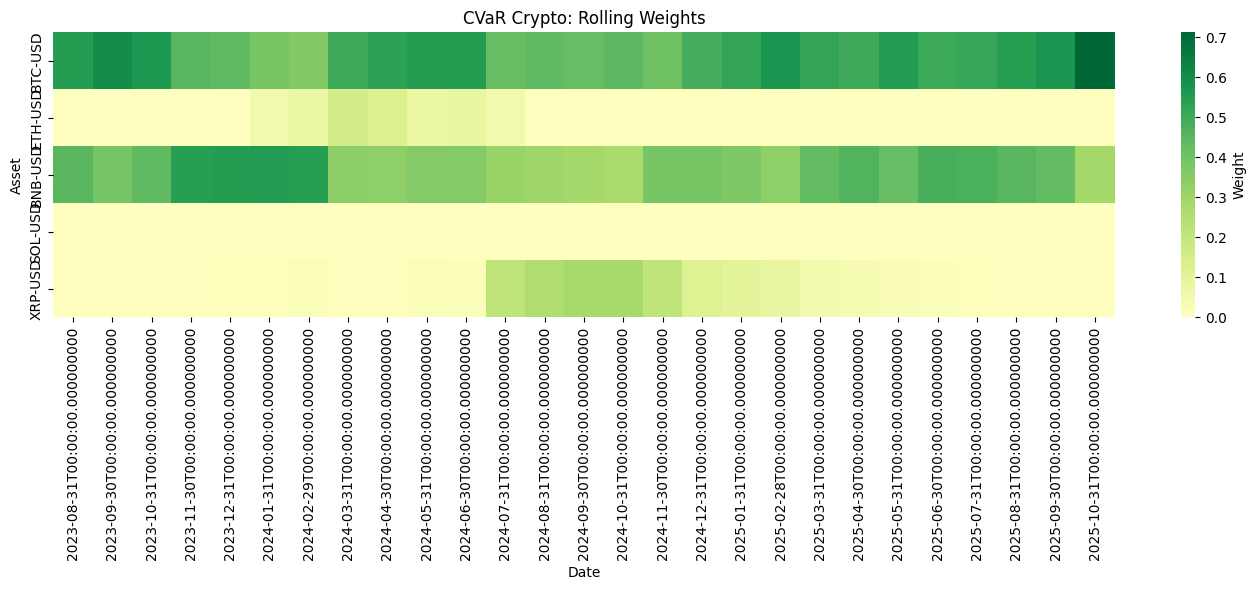

In [7]:
# MVO Comparison
print("\nMethod 1: MVO/Tangency")
plot_comparison({'Trad MVO': mvo_trad_rets, 'Crypto MVO': mvo_crypto_rets}, 'MVO', 'mvo')
plot_weights_heatmap(mvo_trad_wts, 'MVO Traditional: Rolling Weights', 'weights_mvo_trad.png')
plot_weights_heatmap(mvo_crypto_wts, 'MVO Crypto: Rolling Weights', 'weights_mvo_crypto.png')

# Risk Parity Comparison
print("\nMethod 2: Risk Parity")
plot_comparison({'Trad RP': rp_trad_rets, 'Crypto RP': rp_crypto_rets}, 'Risk Parity', 'rp')
plot_weights_heatmap(rp_trad_wts, 'Risk Parity Traditional: Rolling Weights', 'weights_rp_trad.png')
plot_weights_heatmap(rp_crypto_wts, 'Risk Parity Crypto: Rolling Weights', 'weights_rp_crypto.png')

# CVaR Comparison
print("\nMethod 3: CVaR-Constrained")
plot_comparison({'Trad CVaR': cvar_trad_rets, 'Crypto CVaR': cvar_crypto_rets}, 'CVaR', 'cvar')
plot_weights_heatmap(cvar_trad_wts, 'CVaR Traditional: Rolling Weights', 'weights_cvar_trad.png')
plot_weights_heatmap(cvar_crypto_wts, 'CVaR Crypto: Rolling Weights', 'weights_cvar_crypto.png')


## 6. Comprehensive Comparison: All Portfolios


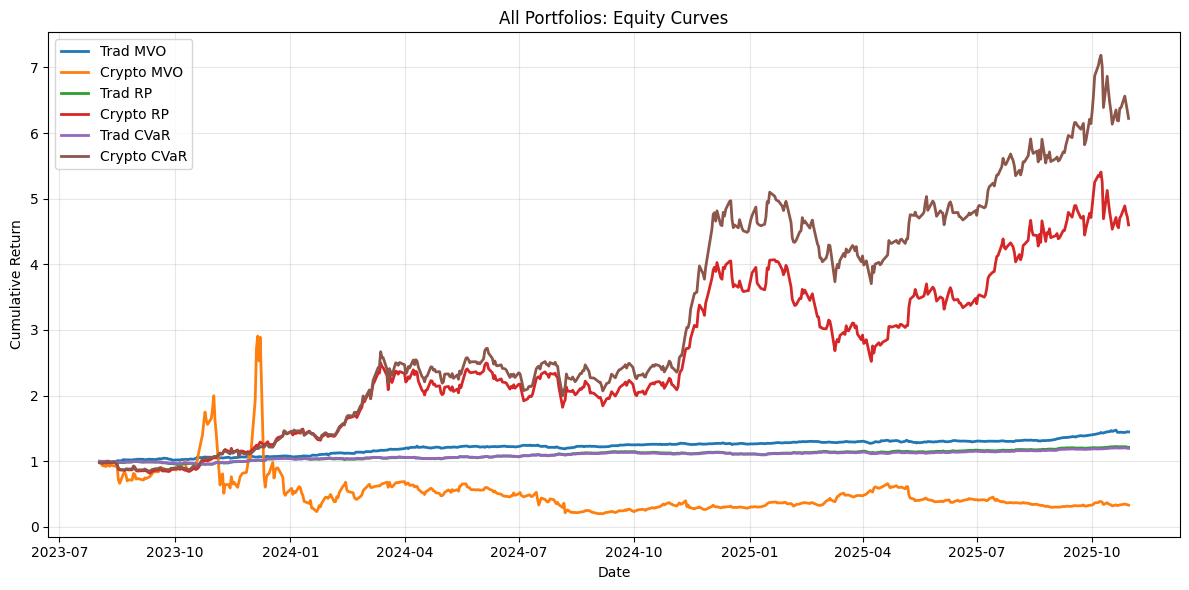

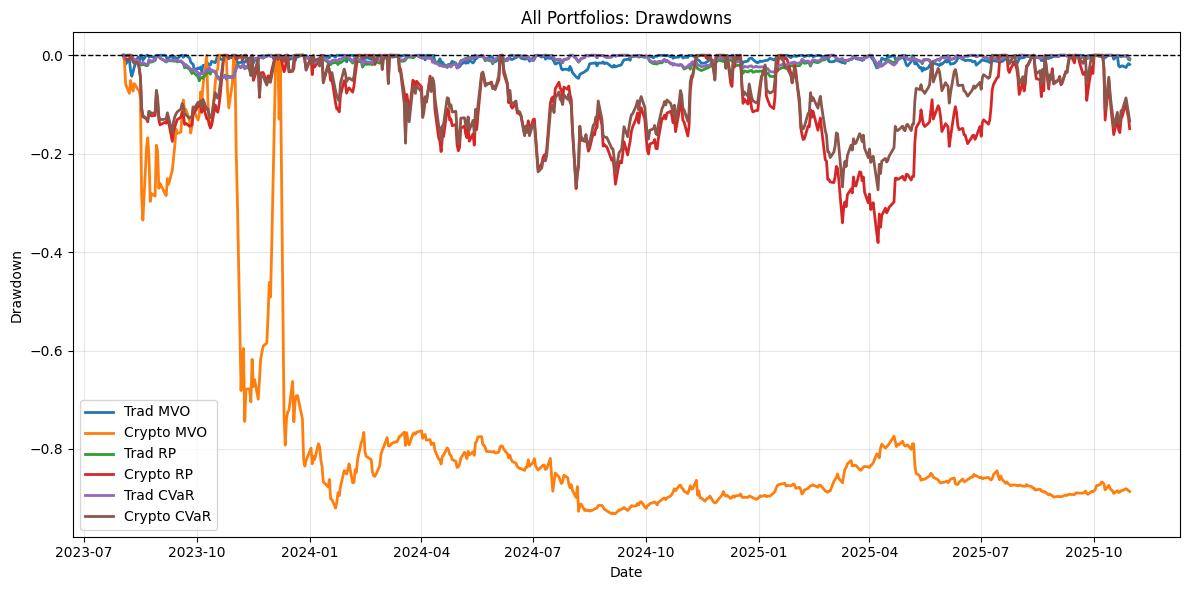

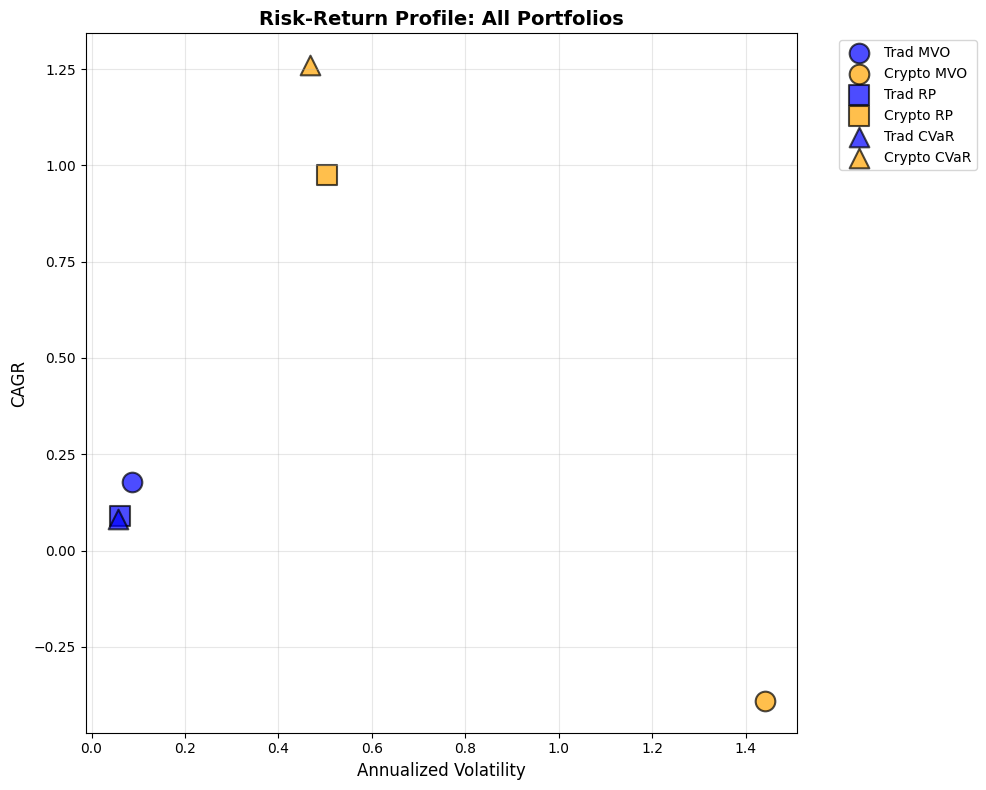

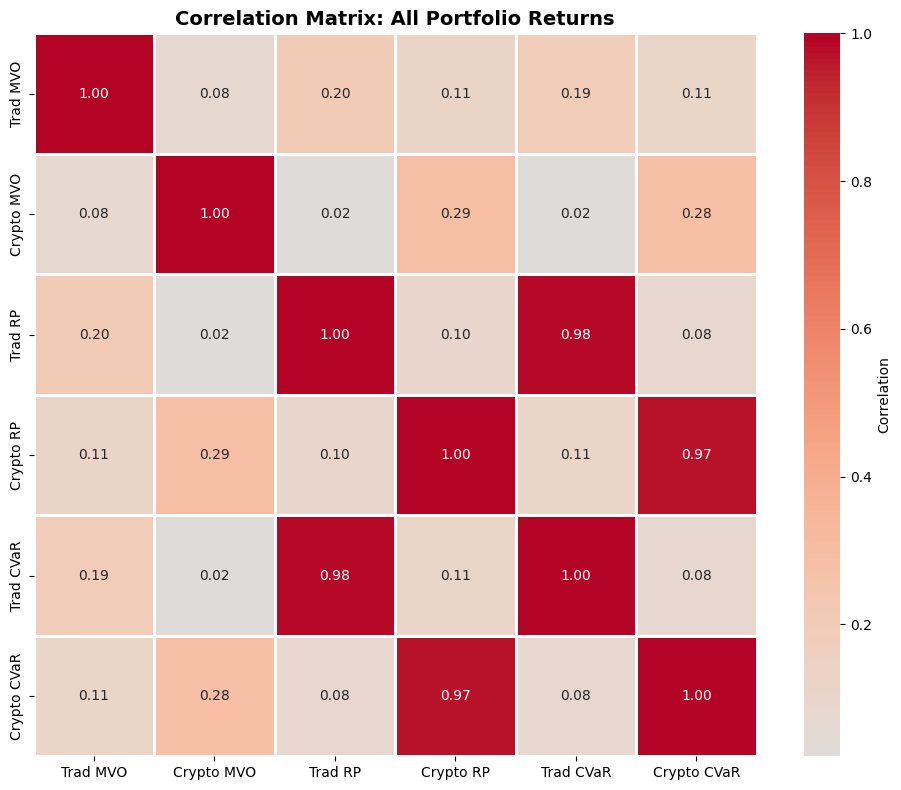

In [8]:
# All portfolios together
plot_comparison(all_portfolios, 'All Portfolios', 'all_portfolios')

# Risk-Return Scatter
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'Trad': 'blue', 'Crypto': 'orange'}
markers = {'MVO': 'o', 'RP': 's', 'CVaR': '^'}

for name in comparison_df.index:
    asset_type = 'Trad' if 'Trad' in name else 'Crypto'
    method = 'MVO' if 'MVO' in name else ('RP' if 'RP' in name else 'CVaR')
    
    ax.scatter(
        comparison_df.loc[name, 'Ann. Vol'],
        comparison_df.loc[name, 'CAGR'],
        c=colors[asset_type],
        marker=markers[method],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
        label=name
    )

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('CAGR', fontsize=12)
ax.set_title('Risk-Return Profile: All Portfolios', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'all_portfolios_risk_return.png'), dpi=300, bbox_inches='tight')
plt.show()

# Correlation Matrix
all_returns_df = pd.DataFrame(all_portfolios).dropna()
corr_matrix = all_returns_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Correlation Matrix: All Portfolio Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'all_portfolios_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()


## 7. Summary and Key Findings


In [9]:
print("=" * 80)
print("SUMMARY AND KEY FINDINGS")
print("=" * 80)

# Best performers
print("\n### Best Performers by Metric:")
print(f"  Highest CAGR: {comparison_df['CAGR'].idxmax()} ({comparison_df['CAGR'].max():.2%})")
print(f"  Highest Sharpe: {comparison_df['Sharpe'].idxmax()} ({comparison_df['Sharpe'].max():.2f})")
print(f"  Lowest Max DD: {comparison_df['Max DD'].idxmax()} ({comparison_df['Max DD'].max():.2%})")
print(f"  Best CVaR: {comparison_df['CVaR (5%)'].idxmax()} ({comparison_df['CVaR (5%)'].max():.2%})")

# Average by asset class
trad_portfolios = [idx for idx in comparison_df.index if 'Trad' in idx]
crypto_portfolios = [idx for idx in comparison_df.index if 'Crypto' in idx]

print("\n### Average Performance by Asset Class:")
avg_trad = comparison_df.loc[trad_portfolios].mean()
avg_crypto = comparison_df.loc[crypto_portfolios].mean()
avg_comparison = pd.DataFrame({'Traditional': avg_trad, 'Crypto': avg_crypto})
print(avg_comparison)

# Statistical test
best_trad = comparison_df.loc[trad_portfolios, 'Sharpe'].idxmax()
best_crypto = comparison_df.loc[crypto_portfolios, 'Sharpe'].idxmax()

aligned = pd.DataFrame({
    'Trad': all_portfolios[best_trad],
    'Crypto': all_portfolios[best_crypto]
}).dropna()

t_stat, p_value = stats.ttest_ind(aligned['Trad'], aligned['Crypto'])

print(f"\n### Statistical Test (T-test):")
print(f"  Comparing: {best_trad} vs {best_crypto}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at 5% level: {'Yes' if p_value < 0.05 else 'No'}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print(f"All results saved to: {OUT_DIR}/")
print("=" * 80)


SUMMARY AND KEY FINDINGS

### Best Performers by Metric:
  Highest CAGR: Crypto CVaR (126.02%)
  Highest Sharpe: Crypto CVaR (1.98)
  Lowest Max DD: Trad MVO (-4.69%)
  Best CVaR: Trad CVaR (-0.75%)

### Average Performance by Asset Class:
           Traditional  Crypto
CAGR            0.1168  0.6149
Ann. Vol        0.0683  0.8040
Sharpe          1.5970  1.3615
Sortino         2.3940  2.0204
Max DD         -0.0494 -0.5287
CVaR (5%)      -0.0093 -0.1194

### Statistical Test (T-test):
  Comparing: Trad MVO vs Crypto CVaR
  t-statistic: -2.3846
  p-value: 0.0173
  Significant at 5% level: Yes

ANALYSIS COMPLETE
All results saved to: outputs/
